In [70]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as st
from matplotlib import cm, colors, rc
from math import comb
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.spatial.distance import mahalanobis as mh
%matplotlib inline
rc('text', usetex=True)

folder_fig = "figs"
dir_fig = lambda x: os.path.join(folder_fig, x)
np.random.seed(43)

In [3]:
# Read file
file = open("data.txt").readlines()
file = list(map(lambda x: x.replace("\n", "").split("\t"), file))

temperatures = np.array(file, dtype=float)

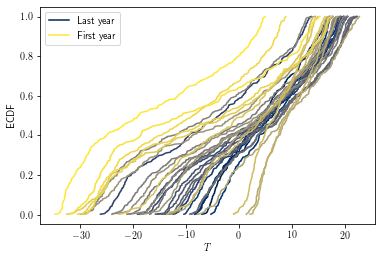

In [4]:
# First point 35 years
color1 = plt.get_cmap('cividis')
color_norm = colors.Normalize(vmin=0, vmax=temperatures.shape[1] - 1)
scalar_map = cm.ScalarMappable(norm=color_norm, cmap=color1)
legends = {0: 'Last year', temperatures.shape[1] - 1: 'First year'}
ecdfs = []
for i in range(temperatures.shape[1]):
    color = scalar_map.to_rgba(i)
    ecdf = ECDF(temperatures[:, i])
    ecdfs.append(ecdf)
    if i in legends.keys():
        plt.plot(ecdf.x, ecdf.y, color=color, label=legends[i])
    else:
        plt.plot(ecdf.x, ecdf.y, color=color)
plt.legend()
plt.xlabel("$T$")
plt.ylabel("ECDF")
plt.savefig(dir_fig("ecdfs.pdf"), bbox_inches='tight')
plt.show()

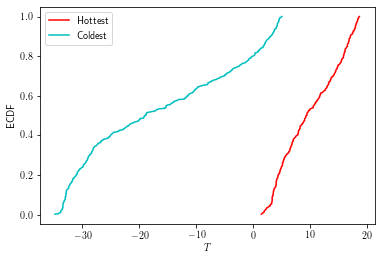

In [5]:
# Plot hottest and coldest, in average.
means = temperatures.mean(axis=0)
index_max = means.argmax()
index_min = means.argmin()

ecdf_max = ecdfs[index_max]
ecdf_min = ecdfs[index_min]

plt.plot(ecdf_max.x, ecdf_max.y, 'r', label='Hottest')
plt.plot(ecdf_min.x, ecdf_min.y, 'c', label='Coldest')
plt.legend()
plt.xlabel("$T$")
plt.ylabel("ECDF")
plt.savefig(dir_fig("ecdfs_extremes.pdf"), bbox_inches='tight')
plt.show()

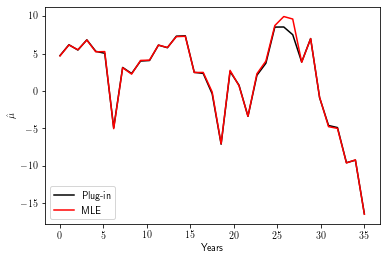

In [6]:
# Calculate area
plug_in_means = []
for i in range(temperatures.shape[1]):
    ecdf = ecdfs[i]
    index_positive = np.where(ecdf.x == ecdf.x[ecdf.x >= 0][0])[0][0]
    
    positive = ecdf.y[index_positive:]
    negative = ecdf.y[:index_positive]
    
    area_positive = 0
    for j in range(len(positive) - 1):
        area_positive += (ecdf.x[j + 1 + index_positive] - ecdf.x[j + index_positive]) * (1 - positive[j])
    
    area_negative = 0
    for j in range(1, len(negative) - 1):
        area_negative += (ecdf.x[j + 1] - ecdf.x[j]) * negative[j]
    
    plug_in_means.append(area_positive - area_negative)

means_estimated = temperatures.mean(axis = 0)
years = np.linspace(0, temperatures.shape[1], temperatures.shape[1])
plt.plot(years, plug_in_means, 'k', label='Plug-in')
plt.plot(years, means_estimated, 'r', label='MLE')
plt.legend()
plt.xlabel("Years")
plt.ylabel("$\hat{\mu}$")
plt.savefig(dir_fig("means.pdf"), bbox_inches='tight')
plt.show()

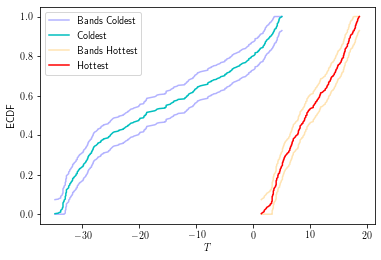

In [7]:
### Bandwidths for hottest and coldest year
alpha = 0.05
epsilon = np.sqrt(1 / (2 * temperatures.shape[0]) * np.log(2 / alpha))

def bands(ecdf):
    lower = np.zeros(len(ecdf.y))
    upper = np.zeros(len(ecdf.y))
    for i in range(len(ecdf.y)):
        lower[i] = max(ecdf.y[i] - epsilon, 0)
        upper[i] = min(ecdf.y[i] + epsilon, 1)
    return lower, upper

lower_cold, upper_cold = bands(ecdf_min)
lower_hot, upper_hot = bands(ecdf_max)

# Plotting cold
plt.plot(ecdf_min.x, lower_cold, 'b', alpha=0.3)
plt.plot(ecdf_min.x, upper_cold, 'b', alpha=0.3, label='Bands Coldest')
plt.plot(ecdf_min.x, ecdf_min.y, 'c', label='Coldest')

# Plotting hot
plt.plot(ecdf_max.x, lower_cold, 'orange', alpha=0.3)
plt.plot(ecdf_max.x, upper_cold, 'orange', alpha=0.3, label='Bands Hottest')
plt.plot(ecdf_max.x, ecdf_max.y, 'r', label='Hottest')

plt.legend()
plt.xlabel("$T$")
plt.ylabel("ECDF")
plt.savefig(dir_fig("ecdf_bands.pdf"), bbox_inches='tight')
plt.show()

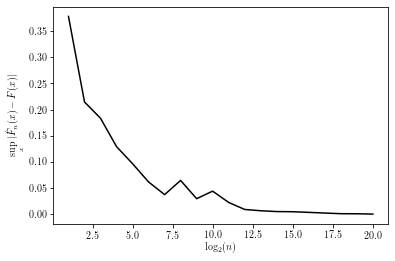

In [9]:
# Weibull simulation
np.random.seed(1234)
nums = np.linspace(1, 20, 20)
data_num = np.exp2(nums).astype(int)
params = [1.5, 0, 1]

differences = []
for i in range(len(data_num)):
    data = st.weibull_max.rvs(*params, size=data_num[i])
    ecdf = ECDF(data)
    real_weibull = st.weibull_max.cdf(ecdf.x, *params)
    
    difference = np.absolute(real_weibull - ecdf.y)
    differences.append(difference.max())

plt.plot(nums, differences, 'k')
plt.xlabel("$\log_2(n)$")
plt.ylabel("$$\sup_x  \,|\hat{F}_n(x) - F(x)|$$")
plt.savefig(dir_fig("weibull.pdf"), bbox_inches='tight')
plt.show()

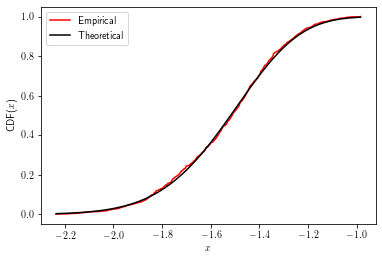

In [10]:
# Order statistic
j = 5
n = 30
params = [1.5, 0, 1]
sims = st.weibull_max.rvs(*params, size=(1000, n))

# Data for order statistic
xj = np.sort(sims, axis=1)[:, j - 1]

# Theoretical function
f_we = lambda x: st.weibull_max.cdf(x, *params)
f_th = lambda x: sum([comb(n, jp) * f_we(x) ** jp * (1 - f_we(x)) ** (n - jp) for jp in range(j, n + 1)])
ecdf = ECDF(xj)
ys_th = list(map(lambda x: f_th(x), ecdf.x[1:]))

# Plotting
plt.plot(ecdf.x, ecdf.y, 'r', label='Empirical')
plt.plot(ecdf.x[1:], ys_th, 'k', label='Theoretical')
plt.legend()
plt.xlabel("$x$")
plt.ylabel("CDF($x$)")
plt.savefig(dir_fig("order.pdf"), bbox_inches='tight')
plt.show()

In [52]:
# Bootstrap method
def bootstrap(series, n, statistic, alpha=0.05, method=0):
    stats = []
    for i in range(n):
        stats.append(statistic(np.random.choice(series, size=len(series))))
    stats = np.array(stats)
    og = statistic(series)
    add = {}
    
    if method == 0:
        aux = (stats - np.mean(stats)) ** 2
        v_boot = 1 / len(stats) * aux.sum()
        z_alpha = st.norm.ppf(1 - alpha / 2)
        interval = (og - z_alpha*np.sqrt(v_boot), og + z_alpha*np.sqrt(v_boot))
        
        add['vboot'] = v_boot
    else:
        theta_alpha_inf = np.quantile(stats, (1 - alpha / 2))
        theta_alpha_sup = np.quantile(stats, alpha / 2)
        interval = (2*og - theta_alpha_inf, 2*og - theta_alpha_sup)
        
    return interval, add

temperatures_max = temperatures[:, index_max]
n = 1000
statistic = lambda x: x.max()
interval, _ = bootstrap(temperatures_max, n, statistic, method=0)
print("Bootstrap interval", interval)
print("Max temperature", statistic(temperatures_max))

Bootstrap interval (18.479697321220375, 18.72030267877963)
Max temperature 18.6


In [145]:
# JackKnife method
def jackknife_bias(series, stastistic):
    og = statistic(series)
    stats = []
    for i in range(len(series)):
        t_i = np.concatenate((series[:i], series[(i+1):]))
        stats.append(statistic(t_i))
    
    t_m = np.mean(stats)
    b_jack = (len(series) - 1) * (t_m - og)
    return b_jack

def jackknife_var(series, statistic):
    og = statistic(series)
    stats = []
    for i in range(len(series)):
        t_i = np.concatenate((series[:i], series[(i+1):]))
        stats.append(statistic(t_i))
    
    ti_v = len(series) * og - (len(series) - 1) * stats
    s2 = ti_v.var(ddof=1)
    
    return s2 / len(series)

b_jack = jackknife_bias(temperatures_max, statistic)
print(b_jack)

v_jack = jackknife_var(temperatures_max, statistic)
print(v_jack)

-0.09972602739917136
7.485590393207431e-08


In [146]:
# Uniform thingy
def error(the, est):
    return abs((the - est) / the) * 100

n = 10000
sample = np.random.random(size=n)
statistic = lambda x: x.max()

theoretical_bias = -1 / (n + 1)

_, additional = bootstrap(sample, 1000, statistic)
vboot = additional['vboot']
print(vboot)

bias_jack = jackknife_bias(sample, statistic)

print()
print("Theoretical", theoretical_bias)
print("Jackknife", bias_jack)
print(error(theoretical_bias, bias_jack))

1.499506620671858e-08

Theoretical -9.999000099990002e-05
Jackknife -0.0001725969836952057
72.61424339357522


In [40]:
# 15 point
temperatures_max[:0]

array([], dtype=float64)